# Project 4 - Group 14

### Setup

In [1]:
#imported libraries go here
import pandas as pd
import seaborn
from collections import Counter
import numpy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import re

### Preprocessing

In [2]:
import re

def corpus_size(lines):
    custom_tokenizer(lines)
    print('____Corpus size____\n\nWords : ',tokens,'\nCharacters: ',characters,'\nVocabulary size: ',len(based))    

with open('../Data/Emotion/train_text.txt',"r", encoding="utf8") as file:
    lines = file.readlines()
# lines = open("").readlines()
def custom_tokenizer(lines):
    global based
    global characters
    global tokens
    #read the data
    with open(lines,"r", encoding="utf8") as file:
        lines = file.readlines()
    #Initialize 2 lists, one containing all real words, as they are presented in the data, another with all words lowercase
    all_words = []
    based_words = []
    characters = 0 #Used to keep track of the total number of characters in data
    tokens = 0 # Used to keep track of the total number of tokens in data
    #for every tweet in the data... 
    for i in lines:
        characters += len(i)
        #find all "words" in the data 
        unfiltered_tokens = re.findall(r"\w+(?:'\w+)?|[^\w\s]",i) 
        #Initialize a list containing all "non-words" tokens
        non_words = []
        for g in range(len(unfiltered_tokens)):
            #if token is specifically: ' append to unfiltered (had problems with apostrophe)
            if bool(re.match(r'\'',unfiltered_tokens[g])):
                non_words.append(unfiltered_tokens[g])
            #if token is not 
            elif not bool(re.match('^[a-zA-Z0-9\']+$',unfiltered_tokens[g])):
                non_words.append(unfiltered_tokens[g])
        #initialize list of all words lowered, if they are not present in non_words
        words = [x.lower() for x in unfiltered_tokens if x not in non_words and x !="user"]
        based_words.extend(words)
        words = ' '.join(words)
        all_words.append(words)
        tokens += len(re.findall(r"\w+(?:'\w+)?|[^\w\s]",i))
    based = Counter(based_words)
    return all_words
tokenizer_words_dict = custom_tokenizer("../Data/Hate/train_text.txt")
tokenizer_words_dict

['nice new signage are you not concerned by beatlemania style hysterical crowds crongregating on you',
 'a woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot',
 'real talk do you have eyes or were they gouged out by a rapefugee',
 'your girlfriend lookin at me like a groupie in this bitch',
 'hysterical woman like',
 'me flirting so tell me about your father',
 'the philippine catholic bishops work for migrant workers should focus on families who are paying the great',
 "i am not going after your ex bf you lieing sack of shit i'm done with you dude that's why i dumped your ass cause your a lieing bitch",
 'when cuffin season is finally over',
 'send home migrants not in need of protection peter dutton tells un hey dutton how about the ones that have stayed and not left the country when they should overstayers why dont you go and round all them up',
 'cory booker and kamala harris competing for most hysterical woman at the kavanaugh hearing

### Characterizing your data

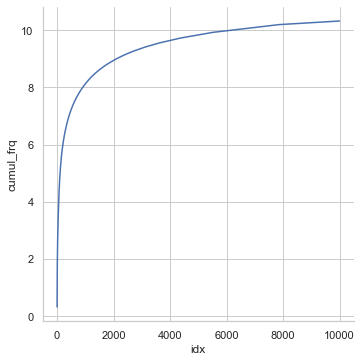

In [3]:
#Using the teachers code from lecture 2 to plot zipf's law in the plots below with minor modifications
#taken from https://learnit.itu.dk/pluginfile.php/296257/mod_resource/content/1/zipf.py

#Plotting for the hate dataset

#running the tokenizer to get the global variable
not_relevant = custom_tokenizer("../Data/Hate/train_text.txt")
frq = pd.DataFrame(based.most_common(), columns=['token', 'frequency'])
# Index in the sorted list
frq['idx'] = frq.index + 1

# Frequency normalised by corpus size
frq['norm_freq'] = frq.frequency / len(based)

# Cumulative normalised frequency
frq['cumul_frq'] = frq.norm_freq.cumsum()

seaborn.set_theme(style='whitegrid')

# Plot: Cumulative frequency by index, top 10000 tokens
seaborn.relplot(x='idx', y='cumul_frq', data=frq[:10000], kind='line')
plt.show()

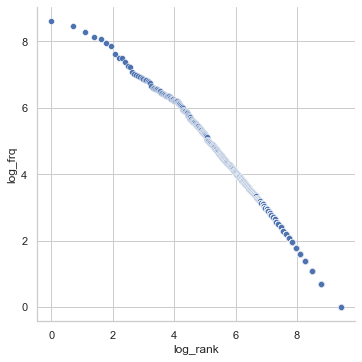

In [4]:
# Plot: Log-log plot for Zipf's law
frq['log_frq'] = numpy.log(frq.frequency)
frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=False))
seaborn.relplot(x='log_rank', y='log_frq', data=frq)
plt.show()

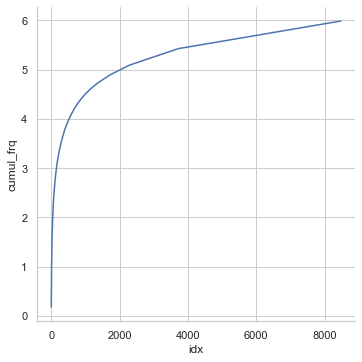

In [5]:
#Plotting for the emotion dataset
#running the tokenizer to get the global variable "based"
not_relevant = custom_tokenizer("../Data/Emotion/train_text.txt")
frq = pd.DataFrame(based.most_common(), columns=['token', 'frequency'])

# Index in the sorted list
frq['idx'] = frq.index + 1

# Frequency normalised by corpus size
frq['norm_freq'] = frq.frequency / len(based)

# Cumulative normalised frequency
frq['cumul_frq'] = frq.norm_freq.cumsum()

# Plot: Cumulative frequency by index, top 10000 tokens
seaborn.relplot(x='idx', y='cumul_frq', data=frq, kind='line')
plt.show()

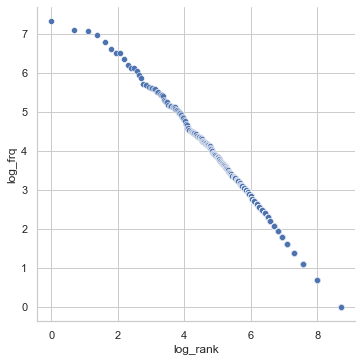

In [6]:
# Plot: Log-log plot for Zipf's law
frq['log_frq'] = numpy.log(frq.frequency)
frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=False))
seaborn.relplot(x='log_rank', y='log_frq', data=frq)
plt.show()

### Manual Annotation and Inter-Annotation Agreement

In [7]:
#Cohen's Kappa

def kappa(h):
    h2 = open("../Data/Hate/train_labels.txt", "r").readlines()[:100]
    index = 0
    errors = 0
    a = 0
    b = 0
    c = 0
    d = 0
    print("--- hate ---")
    print("(0:non-hate, 1:hate)")
    for hm, testhm in zip(h,h2):
        index += 1
        if hm[0] != testhm[0]:
            errors += 1
            print("line:", index, "  error:", hm[0], ":", testhm[0])
        if hm[0] == '1':
            if testhm[0] == '1':
                a += 1
            elif testhm[0] == '0':
                b += 1
        elif hm[0] == '0':
            if testhm[0] == '1':
                c += 1
            elif testhm[0] == '0':
                d += 1
    p0 = (a+d)/(a+b+c+d)
    pyes = ((a+b)/(a+b+c+d))*((a+b)/(a+b+c+d))
    pno = ((c+d)/(a+b+c+d))*((b+d)/(a+b+c+d))
    pe = (pyes + pno)
    print("---")
    print("p0: ", p0) #percentage correct
    print("pyes: ", pyes) #probability that both were randomly labeled as hate
    print("pno: ", pno) #probability both were randomly labeled as non-hate
    print("pe: ", pe) #overall random agreement probability 
    print("Agreement: ", ((p0 - pe)/(1-pe))) #inter-rater reliability
    return p0,pe

h1 = open("../Data/Hate/Christian_train_labels.txt", "r").readlines()
h2 = open("../Data/Hate/Cosmin_train_labels.txt", "r").readlines()
h3 = open("../Data/Hate/Daniel_train_labels.txt", "r").readlines()
h4 = open("../Data/Hate/Jacob_train_labels.txt", "r").readlines()

print("Christian's")
p0_1,pe_1 = kappa(h1)
print("---------------------")
print("Cosmin's")
p0_2,pe_2 = kappa(h2)
print("---------------------")
print("Daniel's")
p0_3,pe_3 = kappa(h3)
print("---------------------")
print("Jacob's")
p0_4,pe_4 = kappa(h4)

#calculating the average
p0_average = (p0_1+p0_2+p0_3+p0_4)/4
pe_average = (pe_1+pe_2+pe_3+pe_4)/4

print("---------------------")
print("Average score")
print("p0: ", p0_average)
print("pe: ", pe_average)
print("Agreement: ",((p0_average - pe_average)/(1-pe_average)))

Christian's
--- hate ---
(0:non-hate, 1:hate)
line: 1   error: 1 : 0
line: 2   error: 0 : 1
line: 5   error: 1 : 0
line: 7   error: 1 : 0
line: 20   error: 0 : 1
line: 24   error: 1 : 0
line: 27   error: 1 : 0
line: 38   error: 1 : 0
line: 39   error: 1 : 0
line: 40   error: 1 : 0
line: 45   error: 1 : 0
line: 46   error: 0 : 1
line: 49   error: 0 : 1
line: 54   error: 0 : 1
line: 56   error: 1 : 0
line: 61   error: 1 : 0
line: 69   error: 1 : 0
line: 71   error: 1 : 0
line: 72   error: 1 : 0
line: 76   error: 1 : 0
line: 77   error: 0 : 1
line: 87   error: 1 : 0
line: 90   error: 1 : 0
line: 91   error: 0 : 1
line: 93   error: 1 : 0
line: 95   error: 0 : 1
line: 97   error: 1 : 0
line: 99   error: 0 : 1
---
p0:  0.72
pyes:  0.3364
pno:  0.2184
pe:  0.5548
Agreement:  0.3710691823899371
---------------------
Cosmin's
--- hate ---
(0:non-hate, 1:hate)
line: 4   error: 0 : 1
line: 5   error: 1 : 0
line: 9   error: 1 : 0
line: 18   error: 1 : 0
line: 19   error: 0 : 1
line: 25   error: 1 

### Classifier

Hate speech dataset using CountVectorizer

In [8]:
X = custom_tokenizer('../Data/Hate/train_text.txt')
with open("../Data/Hate/train_labels.txt", "r") as fd:
    y_train = fd.read().splitlines()
with open("../Data/Hate/val_labels.txt", "r") as fd:
    y_val = fd.read().splitlines()
tokenizer_val_set = custom_tokenizer("../Data/Hate/val_text.txt")
#Using 932 features for max features since the test set can support just 932 features and the classifier needs the same number of features
#for the training and validation set
CV = CountVectorizer(max_features=932, min_df=5, max_df=0.7,analyzer='word', ngram_range=(1, 3))
x1_train = CV.fit_transform(X)
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(x1_train, y_train)
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_sgd = SGDClassifier(alpha=0.00001,loss = "perceptron")
clf_sgd= classifier_sgd.fit(x1_train,y_train)
rf = classifier_rf.fit(x1_train, y_train) 

In [9]:

CV2 = CountVectorizer(max_features=932, min_df=5, max_df=0.7,analyzer='word', ngram_range=(1, 3))
x1_test = CV2.fit_transform(tokenizer_val_set)
y_pred = rf.predict(x1_test)
y_pred1 = clf_sgd.predict(x1_test)
y_pred_mlp= clf_mlp.predict(x1_test)


In [10]:
len(CV2.get_feature_names())

932

In [11]:


print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val,y_pred1))
print(classification_report(y_val,y_pred1))
print(accuracy_score(y_val, y_pred1))
print(confusion_matrix(y_val,y_pred_mlp))
print(classification_report(y_val,y_pred_mlp))
print(accuracy_score(y_val, y_pred_mlp))

[[339 234]
 [222 205]]
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       573
           1       0.47      0.48      0.47       427

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.55      0.54      0.54      1000

0.544
[[418 155]
 [281 146]]
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       573
           1       0.49      0.34      0.40       427

    accuracy                           0.56      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.55      0.56      0.55      1000

0.564
[[416 157]
 [276 151]]
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       573
           1       0.49      0.35      0.41       427

    accuracy                           0.57      1000
   macro avg       0.55      0.54      0.53    

In [12]:


# with open("../Data/Hate/train_labels.txt", "r") as fd:
#     y_train = fd.read().splitlines()
tfidfconverter = TfidfVectorizer(max_features=911, min_df=5, max_df=0.7,analyzer = 'word',ngram_range=(1, 2))
X_train = tfidfconverter.fit_transform(X).toarray()

classifier_sgd = SGDClassifier(alpha=0.00001,loss = "perceptron")
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)
rf2  = classifier_rf.fit(X_train, y_train)
sgd2 = classifier_sgd.fit(X_train,y_train) 

In [13]:

# tokenizer_words_dict2 = custom_tokenizer("../Data/Hate/val_text.txt")
tfidfconverter2 = TfidfVectorizer(max_features=911, min_df=5, max_df=0.7,analyzer = 'word',ngram_range=(1, 2))
X_test = tfidfconverter2.fit_transform(tokenizer_val_set).toarray()

y_pred2 = rf2.predict(X_test)
y_pred3 = sgd2.predict(X_test)
y_pred_mlp_val = clf_mlp.predict(X_test)

In [14]:
len(tfidfconverter2.get_feature_names())

911

In [15]:
# with open("../Data/Hate/val_labels.txt", "r") as fd:
#     y_test = fd.read().splitlines()
print(confusion_matrix(y_val,y_pred2))
print(classification_report(y_val,y_pred2))
print(accuracy_score(y_val, y_pred2))
print(confusion_matrix(y_val,y_pred3))
print(classification_report(y_val,y_pred3))
print(accuracy_score(y_val, y_pred3))
print(confusion_matrix(y_val,y_pred_mlp_val))
print(classification_report(y_val,y_pred_mlp_val))
print(accuracy_score(y_val, y_pred_mlp_val))

[[324 249]
 [247 180]]
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       573
           1       0.42      0.42      0.42       427

    accuracy                           0.50      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.50      0.50      0.50      1000

0.504
[[139 434]
 [106 321]]
              precision    recall  f1-score   support

           0       0.57      0.24      0.34       573
           1       0.43      0.75      0.54       427

    accuracy                           0.46      1000
   macro avg       0.50      0.50      0.44      1000
weighted avg       0.51      0.46      0.43      1000

0.46
[[295 278]
 [227 200]]
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       573
           1       0.42      0.47      0.44       427

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49     

Emotion dataset,Count Vectorizer,validation test

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

with open("../Data/Emotion/train_labels.txt", "r") as fd:
    y_train_emotion = fd.read().splitlines()
X_emotion = custom_tokenizer("../Data/Emotion/train_text.txt")
tokenizer_emotion_val_set = custom_tokenizer("../Data/Emotion/val_text.txt")
with open("../Data/Emotion/val_labels.txt", "r") as fd:
    y_val_emotion = fd.read().splitlines()

CV = CountVectorizer(max_features=405, min_df=3, max_df=0.8,analyzer='word', ngram_range=(1, 3))
x1_train_emotion = CV.fit_transform(X_emotion)

clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(x1_train_emotion, y_train_emotion)
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_sgd = SGDClassifier(alpha=0.00001,loss = "log")
clf_sgd= classifier_sgd.fit(x1_train_emotion,y_train_emotion)
rf = classifier_rf.fit(x1_train_emotion, y_train_emotion) 

In [17]:

CV2 = CountVectorizer(max_features=405, min_df=3, max_df=0.8,analyzer='word', ngram_range=(1, 3))
x1_test = CV2.fit_transform(tokenizer_emotion_val_set)
y_pred = rf.predict(x1_test)
y_pred1 = clf_sgd.predict(x1_test)
y_pred_mlpx= clf_mlp.predict(x1_test)

In [18]:
len(CV2.get_feature_names())

405

In [19]:


print(confusion_matrix( y_val_emotion,y_pred))
print(classification_report( y_val_emotion,y_pred))
print(accuracy_score( y_val_emotion, y_pred))
print(confusion_matrix( y_val_emotion,y_pred1))
print(classification_report( y_val_emotion,y_pred1))
print(accuracy_score( y_val_emotion, y_pred1))
print(confusion_matrix( y_val_emotion,y_pred_mlpx))
print(classification_report( y_val_emotion,y_pred_mlpx))
print(accuracy_score( y_val_emotion, y_pred_mlpx))

[[93 24 10 33]
 [43 22  6 26]
 [17  6  0  5]
 [52 18  3 16]]
              precision    recall  f1-score   support

           0       0.45      0.58      0.51       160
           1       0.31      0.23      0.26        97
           2       0.00      0.00      0.00        28
           3       0.20      0.18      0.19        89

    accuracy                           0.35       374
   macro avg       0.24      0.25      0.24       374
weighted avg       0.32      0.35      0.33       374

0.3502673796791444
[[84 11 20 45]
 [43 13  9 32]
 [13  3  1 11]
 [46 14 11 18]]
              precision    recall  f1-score   support

           0       0.45      0.53      0.49       160
           1       0.32      0.13      0.19        97
           2       0.02      0.04      0.03        28
           3       0.17      0.20      0.18        89

    accuracy                           0.31       374
   macro avg       0.24      0.22      0.22       374
weighted avg       0.32      0.31      0.30 

In [20]:

tfidfconverter = TfidfVectorizer(max_features=405, min_df=3, max_df=0.8,analyzer = 'word',ngram_range=(1, 3))
X_train_emotion = tfidfconverter.fit_transform(X_emotion).toarray()

classifier_sgd = SGDClassifier(alpha=0.00001,loss = "perceptron")
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0,criterion="entropy")
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(X_train_emotion, y_train_emotion)
rf2  = classifier_rf.fit(X_train_emotion, y_train_emotion)
sgd2 = classifier_sgd.fit(X_train_emotion,y_train_emotion) 

In [21]:

tfidfconverter2 = TfidfVectorizer(max_features=405, min_df=3, max_df=0.8,analyzer = 'word',ngram_range=(1, 3))
X_test = tfidfconverter2.fit_transform(tokenizer_emotion_val_set).toarray()

y_pred2 = rf2.predict(X_test)
y_pred3 = sgd2.predict(X_test)
y_pred4 = clf_mlp.predict(X_test)

In [22]:
len(tfidfconverter2.get_feature_names())

405

In [23]:

print(confusion_matrix(y_val_emotion,y_pred2))
print(classification_report(y_val_emotion,y_pred2))
print(accuracy_score(y_val_emotion, y_pred2))
print(confusion_matrix(y_val_emotion,y_pred3))
print(classification_report(y_val_emotion,y_pred3))
print(accuracy_score(y_val_emotion, y_pred3))
print(confusion_matrix(y_val_emotion,y_pred4))
print(classification_report(y_val_emotion,y_pred4))
print(accuracy_score(y_val_emotion, y_pred4))

[[87 26 11 36]
 [46 18  6 27]
 [16  7  0  5]
 [49 21  3 16]]
              precision    recall  f1-score   support

           0       0.44      0.54      0.49       160
           1       0.25      0.19      0.21        97
           2       0.00      0.00      0.00        28
           3       0.19      0.18      0.18        89

    accuracy                           0.32       374
   macro avg       0.22      0.23      0.22       374
weighted avg       0.30      0.32      0.31       374

0.3235294117647059
[[86 18 12 44]
 [34 19  3 41]
 [11  7  1  9]
 [40 20  4 25]]
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       160
           1       0.30      0.20      0.24        97
           2       0.05      0.04      0.04        28
           3       0.21      0.28      0.24        89

    accuracy                           0.35       374
   macro avg       0.26      0.26      0.26       374
weighted avg       0.35      0.35      0.34 

Test set

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


with open("../Data/Hate/train_labels.txt", "r") as fd:
    y_train = fd.read().splitlines()
tokenizer_test_set_hate = custom_tokenizer("../Data/Hate/test_text.txt")
with open("../Data/Hate/test_labels.txt", "r") as fd:
    y_test = fd.read().splitlines()

CV = CountVectorizer(max_features=2500, min_df=5, max_df=0.7,analyzer='word', ngram_range=(1, 2))
x1_train = CV.fit_transform(X)
print(x1_train)
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(x1_train, y_train)
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_sgd = SGDClassifier(alpha=0.0001,loss = "log")
clf_sgd= classifier_sgd.fit(x1_train,y_train)
rf = classifier_rf.fit(x1_train, y_train) 

  (0, 1354)	1
  (0, 1349)	1
  (0, 175)	1
  (0, 2435)	2
  (0, 1372)	1
  (0, 455)	1
  (0, 352)	1
  (0, 933)	1
  (0, 1439)	1
  (0, 190)	1
  (0, 2466)	1
  (0, 1449)	1
  (1, 2435)	2
  (1, 2383)	1
  (1, 2339)	1
  (1, 756)	1
  (1, 2074)	1
  (1, 1699)	1
  (1, 2433)	1
  (1, 540)	1
  (1, 1784)	1
  (1, 1035)	1
  (1, 1119)	1
  (1, 888)	1
  (1, 1910)	1
  :	:
  (8998, 1533)	1
  (8998, 106)	1
  (8998, 2192)	1
  (8999, 2435)	1
  (8999, 1372)	1
  (8999, 2466)	1
  (8999, 2485)	1
  (8999, 992)	1
  (8999, 289)	1
  (8999, 1929)	1
  (8999, 2352)	1
  (8999, 1331)	1
  (8999, 788)	2
  (8999, 277)	1
  (8999, 759)	1
  (8999, 1712)	1
  (8999, 1801)	1
  (8999, 2358)	1
  (8999, 245)	1
  (8999, 1012)	1
  (8999, 1932)	1
  (8999, 1518)	1
  (8999, 446)	1
  (8999, 300)	1
  (8999, 882)	1


In [25]:


CV2 = CountVectorizer(max_features=2500, min_df=5, max_df=0.7,analyzer='word', ngram_range=(1, 2))
x1_test = CV2.fit_transform(tokenizer_test_set_hate)
y_pred = rf.predict(x1_test)
y_pred1 = clf_sgd.predict(x1_test)
y_pred_mlp= clf_mlp.predict(x1_test)


In [26]:

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred1))
print(classification_report(y_test,y_pred1))
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test,y_pred_mlp))
print(classification_report(y_test,y_pred_mlp))
print(accuracy_score(y_test, y_pred_mlp))

[[935 783]
 [595 657]]
              precision    recall  f1-score   support

           0       0.61      0.54      0.58      1718
           1       0.46      0.52      0.49      1252

    accuracy                           0.54      2970
   macro avg       0.53      0.53      0.53      2970
weighted avg       0.55      0.54      0.54      2970

0.5360269360269361
[[1327  391]
 [ 891  361]]
              precision    recall  f1-score   support

           0       0.60      0.77      0.67      1718
           1       0.48      0.29      0.36      1252

    accuracy                           0.57      2970
   macro avg       0.54      0.53      0.52      2970
weighted avg       0.55      0.57      0.54      2970

0.5683501683501684
[[1151  567]
 [ 770  482]]
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      1718
           1       0.46      0.38      0.42      1252

    accuracy                           0.55      2970
   macro avg 

In [27]:

tfidfconverter = TfidfVectorizer(max_features=2541, min_df=5, max_df=0.7,analyzer = 'word',ngram_range=(1, 2))
X_train = tfidfconverter.fit_transform(X).toarray()

classifier_sgd = SGDClassifier(alpha=0.001,loss = "log")
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)
rf2  = classifier_rf.fit(X_train, y_train)
sgd2 = classifier_sgd.fit(X_train,y_train) 

In [28]:

tokenizer_words_dict2 = custom_tokenizer("../Data/Hate/test_text.txt")
tfidfconverter2 = TfidfVectorizer(max_features=2541,min_df=5, max_df=0.7,analyzer = 'word',ngram_range=(1, 2))
X_test = tfidfconverter2.fit_transform(tokenizer_words_dict2).toarray()

y_pred2 = rf2.predict(X_test)
y_pred3 = sgd2.predict(X_test)
y_pred_mlp = clf_mlp.predict(X_test)

In [29]:
len(tfidfconverter2.get_feature_names())

2541

In [30]:
with open("../Data/Hate/test_labels.txt", "r") as fd:
    y_test = fd.read().splitlines()
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test,y_pred3))
print(classification_report(y_test,y_pred3))
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test,y_pred_mlp))
print(classification_report(y_test,y_pred_mlp))
print(accuracy_score(y_test, y_pred_mlp))

[[1377  341]
 [ 931  321]]
              precision    recall  f1-score   support

           0       0.60      0.80      0.68      1718
           1       0.48      0.26      0.34      1252

    accuracy                           0.57      2970
   macro avg       0.54      0.53      0.51      2970
weighted avg       0.55      0.57      0.54      2970

0.5717171717171717
[[1651   67]
 [1173   79]]
              precision    recall  f1-score   support

           0       0.58      0.96      0.73      1718
           1       0.54      0.06      0.11      1252

    accuracy                           0.58      2970
   macro avg       0.56      0.51      0.42      2970
weighted avg       0.57      0.58      0.47      2970

0.5824915824915825
[[935 783]
 [679 573]]
              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1718
           1       0.42      0.46      0.44      1252

    accuracy                           0.51      2970
   macro avg 

In [31]:
tokenizer_emotion_test_set = custom_tokenizer("../Data/Emotion/test_text.txt")
with open("../Data/Emotion/test_labels.txt", "r") as fd:
    y_test_emotion = fd.read().splitlines()

CV = CountVectorizer(max_features=1657, min_df=3, max_df=0.8,analyzer='word', ngram_range=(1, 4))
x1_train = CV.fit_transform(X_emotion)
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(x1_train, y_train_emotion)
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_sgd = SGDClassifier(alpha=0.00001,loss = "perceptron")
clf_sgd= classifier_sgd.fit(x1_train,y_train_emotion)
rf = classifier_rf.fit(x1_train, y_train_emotion) 

In [32]:

CV2 = CountVectorizer(max_features=1657, min_df=3, max_df=0.8,analyzer='word', ngram_range=(1, 4))
x1_test = CV2.fit_transform(tokenizer_emotion_test_set)
y_pred = rf.predict(x1_test)
y_pred1 = clf_sgd.predict(x1_test)
y_pred_mlp2= clf_mlp.predict(x1_test)

In [33]:
len(CV2.get_feature_names())

1657

In [34]:

print(confusion_matrix(y_test_emotion,y_pred))
print(classification_report(y_test_emotion,y_pred))
print(accuracy_score(y_test_emotion, y_pred))
print(confusion_matrix(y_test_emotion,y_pred1))
print(classification_report(y_test_emotion,y_pred1))
print(accuracy_score(y_test_emotion, y_pred1))
print(confusion_matrix(y_test_emotion,y_pred1))
print(classification_report(y_test_emotion,y_pred_mlp2))
print(accuracy_score(y_test_emotion,y_pred_mlp2))

[[130 172   4 252]
 [ 61 134   3 160]
 [ 24  44   9  46]
 [ 67 114   4 197]]
              precision    recall  f1-score   support

           0       0.46      0.23      0.31       558
           1       0.29      0.37      0.33       358
           2       0.45      0.07      0.13       123
           3       0.30      0.52      0.38       382

    accuracy                           0.33      1421
   macro avg       0.38      0.30      0.29      1421
weighted avg       0.37      0.33      0.32      1421

0.330752990851513
[[203 186  32 137]
 [117 152   4  85]
 [ 30  35  12  46]
 [126 111  18 127]]
              precision    recall  f1-score   support

           0       0.43      0.36      0.39       558
           1       0.31      0.42      0.36       358
           2       0.18      0.10      0.13       123
           3       0.32      0.33      0.33       382

    accuracy                           0.35      1421
   macro avg       0.31      0.30      0.30      1421
weighted avg 

Emotion dataset,test set 

In [35]:



tfidfconverter = TfidfVectorizer(max_features=1657,min_df=5, max_df=0.8,analyzer = 'word',ngram_range=(1, 3))
X_train = tfidfconverter.fit_transform(X_emotion).toarray()

classifier_sgd = SGDClassifier(alpha=0.00001,loss = "perceptron")
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0,criterion="entropy")
clf_mlp = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train_emotion)
rf2  = classifier_rf.fit(X_train, y_train_emotion)
sgd2 = classifier_sgd.fit(X_train,y_train_emotion) 

In [36]:

tfidfconverter2 = TfidfVectorizer(max_features=1657,min_df=3, max_df=0.8,analyzer = 'word',ngram_range=(1, 4))
X_test = tfidfconverter2.fit_transform(tokenizer_emotion_test_set).toarray()

y_pred2 = rf2.predict(X_test)
y_pred3 = sgd2.predict(X_test)
y_pred4 = clf_mlp.predict(X_test)

In [37]:
len(tfidfconverter2.get_feature_names())

1657

In [38]:

print(confusion_matrix(y_test_emotion,y_pred2))
print(classification_report(y_test_emotion,y_pred2))
print(accuracy_score(y_test_emotion, y_pred2))
print(confusion_matrix(y_test_emotion,y_pred3))
print(classification_report(y_test_emotion,y_pred3))
print(accuracy_score(y_test_emotion, y_pred3))
print(confusion_matrix(y_test_emotion,y_pred4))
print(classification_report(y_test_emotion,y_pred4))
print(accuracy_score(y_test_emotion, y_pred4))

[[141  84   7 326]
 [ 80  42   7 229]
 [ 45  10   0  68]
 [ 88  45   9 240]]
              precision    recall  f1-score   support

           0       0.40      0.25      0.31       558
           1       0.23      0.12      0.16       358
           2       0.00      0.00      0.00       123
           3       0.28      0.63      0.39       382

    accuracy                           0.30      1421
   macro avg       0.23      0.25      0.21      1421
weighted avg       0.29      0.30      0.26      1421

0.2976776917663617
[[248 113  72 125]
 [163  69  28  98]
 [ 54  22  12  35]
 [185  72  29  96]]
              precision    recall  f1-score   support

           0       0.38      0.44      0.41       558
           1       0.25      0.19      0.22       358
           2       0.09      0.10      0.09       123
           3       0.27      0.25      0.26       382

    accuracy                           0.30      1421
   macro avg       0.25      0.25      0.25      1421
weighted avg